## Objective

Upon a dataset, train a model that is capable of predicting if a piece of news is fake or real. 

**References:**
- **Dataset:** https://www.kaggle.com/code/therealsampat/fake-news-detection/notebook

In [1]:
#Libraries 
import pandas as pd
import numpy as np 
import string
import matplotlib.pyplot as plt
import shap
import sklearn
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

shap.initjs()

In [2]:
#csv reader 
true_stories = pd.read_csv('True.csv', delimiter=",")
true_stories.head(5)
fake_stories = pd.read_csv('Fake.csv', delimiter=",")
fake_stories.head(5)

'''As we can see, both datasets have the same structure ("title", "text", "subject" and "date"), hence it is possible
to merge them into 1 dataFrame that can provide our training and testing data. As none of the datasets 
have a label that can differentiate between real and fake news, we must add a label column before merging both datasets into one. 
True stories will be categorized with 0 and fake stories with 1'''

#Adding label column.
true_stories["Label"] = 0
true_stories.head(5)
fake_stories["Label"] = 1
fake_stories.head(5)

#Reviewing size of our datasets to see if it's well balanced. 
print(true_stories.shape)
print(fake_stories.shape)

#Merging both dataframes with the append method to avoid our data concatanating.
df_stories = true_stories.append(fake_stories, ignore_index = True)
df_stories
df_stories.shape

#Randomize our dataset order so that we can train and test with both possibilities.
df_stories = df_stories.sample(frac=1).reset_index(drop=True)
df_stories

(21417, 5)
(23481, 5)


,title,text,subject,date,Label
0,"BILLIONAIRE, Leftist Author Of Harry Potter Bo...",Big-mouth billionaire and leftist author of th...,politics,"Aug 1, 2017",1
1,‘Anti-Russia’ Escalation? Plans for New US Mar...,21st Century Wire says It seems that US anti-R...,US_News,"October 19, 2016",1
2,KING OBAMA Just Proclaimed The Month Of June W...,So let it be said so let it be done.I don t re...,politics,"May 31, 2016",1
3,PM Orban: Hungary will block any punitive EU a...,BUDAPEST (Reuters) - Hungarian Prime Minister ...,worldnews,"December 22, 2017",0
4,WEST VIRGINIA COAL MINERS Send A Clear Message...,West Virginia has been devastated by a loss of...,politics,"May 5, 2016",1
...,...,...,...,...,...
44893,Trump Has CRAZY Meltdown On ‘Face The Nation’...,Donald Trump and his team are not only some of...,News,"May 1, 2017",1
44894,Myanmar to grant families access to two Reuter...,YANGON (Reuters) - Two Reuters journalists det...,worldnews,"December 23, 2017",0
44895,U.S. spy agencies probe another flank in Russi...,SAN FRANCISCO (Reuters) - Russian hacking of t...,politicsNews,"June 7, 2017",0
44896,Lebanon PM under house arrest in Saudi Arabia:...,"BEIRUT (Reuters) - Saad al-Hariri, who quit as...",worldnews,"November 7, 2017",0


In [3]:
#Evaluation of data.  
#Check if our data is NaN or Null free and get to know what types of variables we are dealing with.  
df_stories.info()

#Data cleaning. In other words, we are eliminating title and date columns because for this example we want to 
#focus solemnly in the text of the stories. 
df_stories = df_stories.drop(["title", "date"], axis=1)
df_stories

#Homogenize data. 
df_stories['text'] = df_stories['text'].apply(lambda x: x.lower())
df_stories

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   Label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


,text,subject,Label
0,big-mouth billionaire and leftist author of th...,politics,1
1,21st century wire says it seems that us anti-r...,US_News,1
2,so let it be said so let it be done.i don t re...,politics,1
3,budapest (reuters) - hungarian prime minister ...,worldnews,0
4,west virginia has been devastated by a loss of...,politics,1
...,...,...,...
44893,donald trump and his team are not only some of...,News,1
44894,yangon (reuters) - two reuters journalists det...,worldnews,0
44895,san francisco (reuters) - russian hacking of t...,politicsNews,0
44896,"beirut (reuters) - saad al-hariri, who quit as...",worldnews,0


In [4]:
#Removal of any punctuation as this info do not add value to our analysis.   
def punctuation_removal(text):
    all_text=[char for char in text if char not in string.punctuation]
    clean_text = ''.join(all_text)
    return clean_text

#punctuation free dataframe.
df_stories["text"] = df_stories["text"].apply(punctuation_removal)
print(type(df_stories["text"]))

#Stopwords Removal as this info do not add value to our analysis. 
stopwords_text_free = list()
for review in df_stories["text"]: 
    stopwords_text_free.append(remove_stopwords(review).replace('</br>', ''))  

<class 'pandas.core.series.Series'>


# Data Visualization and understanding. 

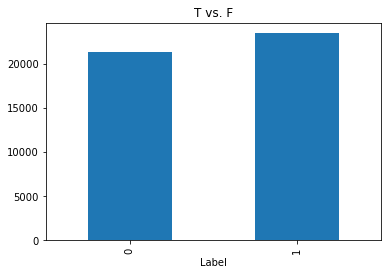

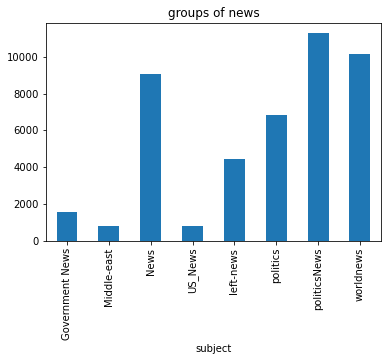

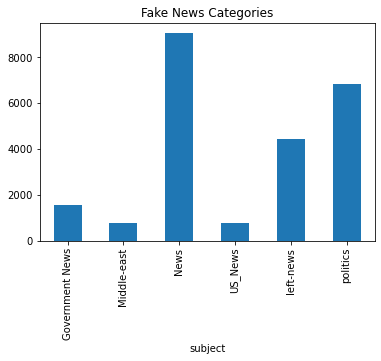

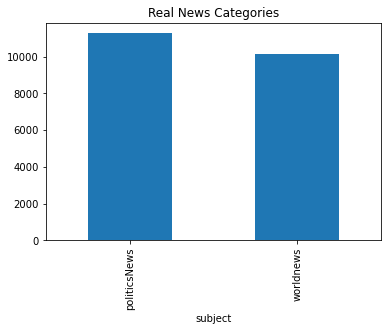

"As we can see in the last 2 bar charts, we have more variety of fake news than real news. At first glanze, this could be \nalarming, but when we observe in detail the information we've got, we now realize that this diference is due to the differences \nfrom both sets. In the real news set, the subjects are not as detailed as in the fake news set, thus we can not take in \nconsideration this parameter to train nor test, because our text could be in 2 categories at the same time giving a \ncontradicting answer or confusing our model. "

In [10]:
#Quantity of fake news vs. True News. 
df_stories.groupby(["Label"])["text"].count().plot(kind="bar",title="T vs. F")
plt.show()

#As we can see in the chart, our data is not well balanced, however this diference is quite small.

#Quantity of groups and news per group. 
subject_group_count=df_stories.groupby("subject")["text"].count().plot(kind="bar", title="groups of news")
plt.show()

#There are 8 groups of news, but we don't know how much data of it is true or false.

#Out of the total of news, how many are true and how many fake?
fake_news_categories = df_stories[df_stories["Label"]==1]
fake_news_categories.groupby("subject")["text"].count().plot(kind="bar", title="Fake News Categories")
plt.show()

real_news_categories = df_stories[df_stories["Label"]==0]
real_news_categories.groupby("subject")["text"].count().plot(kind="bar", title="Real News Categories")
plt.show()

'''As we can see in the last 2 bar charts, we have more variety of fake news than real news. At first glanze, this could be 
alarming, but when we observe in detail the information we've got, we now realize that this diference is due to the differences 
from both sets. In the real news set, the subjects are not as detailed as in the fake news set, thus we can not take in 
consideration this parameter to train nor test, because our text could be in 2 categories at the same time giving a 
contradicting answer or confusing our model. '''


In [6]:
x_train, x_test, y_train, y_test = train_test_split(stopwords_text_free, 
                                                    df_stories["Label"], 
                                                    test_size=0.2, 
                                                    random_state=0)

#TfidfVectorizer = counts how many times a word appears in a document.
#min_df = 10, will not consider those words that appear less than 10 times. 
vectorizer = TfidfVectorizer(min_df=10)

#fit_transform = scalates data and learns from the data scaling. 
x_train = vectorizer.fit_transform(x_train)

x_test = vectorizer.transform(x_test)
print(x_train.shape)
print(x_test.shape)

(35918, 27870)
(8980, 27870)


In [7]:
#Model fit and application. 
model = LogisticRegression(penalty="l2", C=0.1)
model.fit(x_train,y_train)
pred = model.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4276
           1       0.98      0.97      0.97      4704

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



Confusion matrix, without normalization


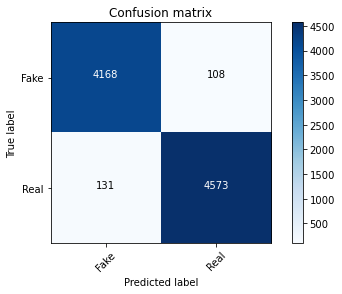

In [13]:
#Ploting confusion matrix. 
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])   


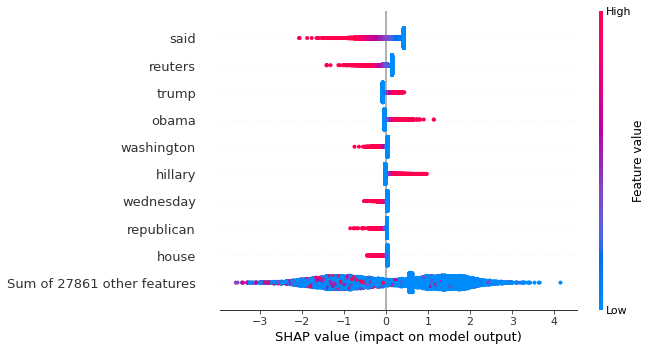

'As the chart shows, words like "said" or "reuters" can be a sign that the piece of news is fake. While names like "trump", \n"obama" and "hilary" give a certain confirmation of real news.'

In [11]:
#Understanding which words may be contemplated for fake or real news and their respective weights. 
explainer = shap.Explainer(model, x_train, feature_names=vectorizer.get_feature_names())
shap_values = explainer(x_test)
shap.plots.beeswarm(shap_values)

'''As the chart shows, words like "said" or "reuters" can be a sign that the piece of news is fake. While names like "trump", 
"obama" and "hilary" give a certain confirmation of real news.'''